# Unraveling price elasticity of demand with Atoti

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.9.9-blue">

## Overview

In this notebook, we will apply the concept of [price elasticity of demand](https://en.wikipedia.org/wiki/Price_elasticity_of_demand) in the domain of insurance pricing. Insurance companies give their customers a quote for the premium they would charge to insure the customer's vehicle, just like most applications of price elasticity, the customer may choose one insurance provider over other based on the quoted price, amongst other factors.  

Here, we are using this [dataset from Kaggle](https://www.kaggle.com/ranja7/vehicle-insurance-customer-data) which has been further augmented by adding synthetic data to it. The dataset is the quotes data for vehicle insurance, with the policy sales being the target variable.  We will be building a predictive model for the quotes sales and then using Atoti and the model to identify different buckets of customers across different segments depending on their price sensitivity.  

The notebook has three main sections:

1. **Predictive Modelling:** We will start off with building a predictive model, and identify the feature importance to see which factors are affecting the model. 
2. **Identifying and visualising the KPIs:** We will use the model to identify different KPIs from the data.
3. **Price Elasticity with Atoti:** Now we wil create different what-if scenarios based on the price using Atoti and find out the impact of these on the above-mentioned KPIs.

Let's get started with demystifying the price elasticity modeling, thanks to Atoti!

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=price-elasticity" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import atoti as tt
import statsmodels.api as sm

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, recall_score, roc_auc_score

# Part 1: Predictive Modelling

We begin with loading the training and test datasets and then we try different models to find the best results. Once, we have found the best model, we shall see which features are the main rivers for the predictive ability of the selected model. 

## 1.1 Loading and preparing the data  

### Loading and viewing the training and the test dataset

In [2]:
df = pd.read_csv("https://data.atoti.io/notebooks/price-elasticity/data.csv")
test_df = pd.read_csv("https://data.atoti.io/notebooks/price-elasticity/test_df.csv")

In [3]:
print(df.shape)
df.head()

(45707, 19)


,cust_id,Sale,Driver_Age,Vehicle_Value,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Marital_Status,Tax,State,CLTV,Coverage_Type,Education,Employment_Status,Location_Code,Sales_Channel,Months_Policy_Inception,Policy_Type
0,402933470644,0,67.0,2000.0,445.82,9000.0,386.17,0.79,D,NaN,Washington,2962.7,Extended,Doctor,Disabled,Rural,Agent,90,Corporate Auto
1,1727686457919,1,35.0,9000.0,NaN,9000.0,406.26,10.58,M,52.37,Nevada,2615.1,Basic,High School or Below,Employed,Rural,Web,92,Corporate Auto
2,54216290243,1,34.0,10000.0,737.83,7000.0,437.45,9.09,M,73.78,California,10629.2,Extended,Master,Medical Leave,Rural,Web,93,Special Auto
3,844267021428,1,34.0,10000.0,582.42,6000.0,506.71,2.78,M,58.24,Arizona,9624.9,Premium,Master,Employed,Rural,Branch,39,Special Auto
4,4695160115211,0,25.0,9000.0,622.56,10000.0,501.31,1.73,M,62.26,California,7781.0,Basic,Bachelor,Unemployed,Urban,Branch,52,Personal Auto


In [4]:
print(test_df.shape)
test_df.head()

(11427, 19)


,cust_id,Sale,Driver_Age,Vehicle_Value,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Marital_Status,Tax,State,CLTV,Coverage_Type,Education,Employment_Status,Location_Code,Sales_Channel,Months_Policy_Inception,Policy_Type
0,9447656335642,1,NaN,8000.0,447.64,4000.0,409.44,4.00,M,44.76,Washington,7319.6,Premium,High School or Below,Unemployed,Urban,Agent,87,Special Auto
1,1123349069299,0,37.0,6000.0,252.39,5000.0,359.11,4.42,M,25.24,California,9890.2,Extended,Bachelor,Employed,Rural,Agent,12,Personal Auto
2,4467098784674,1,27.0,10000.0,477.80,6000.0,401.06,0.68,S,47.78,Arizona,6297.0,Premium,Master,Disabled,Urban,Branch,65,Corporate Auto
3,869569892903,0,27.0,10000.0,340.29,6000.0,304.35,7.19,M,34.03,Washington,8709.8,Premium,Bachelor,Employed,Rural,Call Center,47,Corporate Auto
4,2237607703548,1,18.0,8000.0,645.61,7000.0,345.25,0.43,M,64.56,Oregon,16675.9,Extended,Bachelor,Medical Leave,Urban,Web,89,Personal Auto


### Splitting the training data into train and validation dataset  
Now for building the machine learning model, we need to split the training data into training and validation datasets.  


In [5]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=36)

In [6]:
# dropping rows with NA
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

## 1.2 Feature Engineering
We split the labels from the features for all the dataset.  
And then, we perform one-hot encoding for all the categorical variables.

In [7]:
# split data into the features (X) and labels (y)

# Training data
X_train = train_df.iloc[:, 2:]
Y_train = train_df.iloc[:, 1]

# Validation data
X_val = val_df.iloc[:, 2:]
Y_val = val_df.iloc[:, 1]

# Test data
X_test = test_df.iloc[:, 2:]
Y_test = test_df.iloc[:, 1]

In [8]:
# One hot encoding for categorical variables
def OH_df(X):
    one_hot = pd.get_dummies(X["Marital_Status"])
    X = X.drop("Marital_Status", axis=1)
    X = X.join(one_hot)

    one_hot = pd.get_dummies(X["State"])
    X = X.drop("State", axis=1)
    X = X.join(one_hot)

    one_hot = pd.get_dummies(X["Coverage_Type"])
    X = X.drop("Coverage_Type", axis=1)
    X = X.join(one_hot)

    one_hot = pd.get_dummies(X["Education"])
    X = X.drop("Education", axis=1)
    X = X.join(one_hot)

    one_hot = pd.get_dummies(X["Employment_Status"])
    X = X.drop("Employment_Status", axis=1)
    X = X.join(one_hot)

    one_hot = pd.get_dummies(X["Location_Code"])
    X = X.drop("Location_Code", axis=1)
    X = X.join(one_hot)

    one_hot = pd.get_dummies(X["Sales_Channel"])
    X = X.drop("Sales_Channel", axis=1)
    X = X.join(one_hot)

    one_hot = pd.get_dummies(X["Policy_Type"])
    X = X.drop("Policy_Type", axis=1)
    X = X.join(one_hot)
    return X

In [9]:
X_train = OH_df(X_train)
X_val = OH_df(X_val)
X_test = OH_df(X_test)

## 1.3 Time to do some predictive modelling!
Here we will be testing the below models for the predictions:  
1. Random forest classifier
2. KNeighbors Classifier
3. Gaussian Naive Bayes Classifier
4. Support Vector Machine based Classifier
5. XG Boost Classifier

In [10]:
rf = RandomForestClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
nb = GaussianNB()
svm = SVC()
xgbc = XGBClassifier()

In [11]:
model_list = [rf, knn, nb, svm, xgbc]

In [12]:
# Training the models on the training dataset
models = []
f1 = []
roc_auc = []
recall = []

for estimator in model_list:
    estimator.fit(X_train.values, Y_train.values.ravel())
    # result = estimator.predict(X_val)
    result = estimator.predict(X_val.values)

    models.append(estimator)
    f1.append(f1_score(Y_val, result))
    recall.append(recall_score(Y_val, result))
    roc_auc.append(roc_auc_score(Y_val, result))

In [13]:
# Compiling the results from all the models on the validation dataset
df_results = pd.DataFrame(
    {"model_name": models, "f1_score": f1, "roc_auc_score": roc_auc, "recall": recall}
)
df_results.head(10)

,model_name,f1_score,roc_auc_score,recall
0,"(DecisionTreeClassifier(max_features='sqrt', r...",0.930929,0.870726,0.947656
1,KNeighborsClassifier(n_jobs=-1),0.860897,0.731611,0.895703
2,GaussianNB(),0.907729,0.853806,0.899219
3,SVC(),0.893333,0.751059,0.968359
4,"XGBClassifier(base_score=None, booster=None, c...",0.932435,0.875875,0.946094


**Hence for this dataset, the best model is XGBClassifier with an F1 of 0.934 and recall of 0.948 on the validation dataset.**

### 1.4 Find the importance of the various features in the model.
Here the hypothesis is, amongst other factors, price should be a very critical factor in deciding whether a customer buys a quote or not.  


In [14]:
# Finding feature importance from the model
sorted_idx = np.argsort(xgbc.feature_importances_)[::-1]

# Finding the top 10 features contributing to the results
for index in sorted_idx[:10]:
    print([X_train.columns[index], xgbc.feature_importances_[index]])

['Price', np.float32(0.24982004)]
['Driver_Age', np.float32(0.061049823)]
['Employed', np.float32(0.05736962)]
['Suburban', np.float32(0.05066818)]
['Personal Auto', np.float32(0.04968583)]
['Unemployed', np.float32(0.042872656)]
['Premium', np.float32(0.030028027)]
['Doctor', np.float32(0.029765725)]
['Special Auto', np.float32(0.028718164)]
['Basic', np.float32(0.027631544)]


### Hence, Price is the most important feature — which makes business sense and goes completely with our hypothesis.

It is important to note that price of the quote has **4 times** more predictive power than the second next feature and **10 times** more predictive than the 10th feature in the list.

Now since we have established that price is one of the most important feature to predict sale, let us try to find the correlation between   price and sales using OLS.

In [15]:
# Verifying these findings by using an OLS model
model = sm.OLS(Y_train, X_train.astype(float))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Sale   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     1299.
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:55:15   Log-Likelihood:                -7876.8
No. Observations:               33264   AIC:                         1.582e+04
Df Residuals:                   33231   BIC:                         1.610e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Driver_Age                 -0.0139      0.000    -45.113      0.000      -0.015      -0.013
Vehicle_Value            2.274e-06      1e-06      2.263      0.024    3.05e-07    4.24e-06
Price                       0.0022   2.06e-05    108.697      0.000       0.002       0.002
Vehicle_Mileage         -3.099e-05   1.26e-06    -24.579      0.000   -3.35e-05   -2.85e-05
Credit_Score            -2.296e-06   1.76e-06     -1.307      0.191   -5.74e-06    1.15e-06
Licence_Length_Years        0.0089      0.001     12.759      0.000       0.008       0.010
Tax                        -0.0025      0.000    -15.158      0.000      -0.003      -0.002
CLTV                    -1.203e-07   2.46e-07     -0.490      0.624   -6.02e-07    3.61e-07
Months_Policy_Inception  2.933e-05    5.9e-05      0.497      0.619   -8.63e-05       0.000
D                           0.0251      0.005      5.350      0.000       0.016       0.034
M                           0.0262      0.004      7.411      0.000       0.019       0.033
S                           0.0295      0.004      8.199      0.000       0.022       0.037
Arizona                     0.0138      0.004      3.685      0.000       0.006       0.021
California                 -0.0147      0.004     -4.149      0.000      -0.022      -0.008
Nevada                      0.0400      0.004     10.447      0.000       0.033       0.048
Oregon                     -0.0042      0.004     -1.166      0.244      -0.011       0.003
Washington                  0.0459      0.004     11.818      0.000       0.038       0.054
Basic                      -0.0103      0.003     -2.984      0.003      -0.017      -0.004
Extended                    0.0259      0.004      7.353      0.000       0.019       0.033
Premium                     0.0652      0.004     17.918      0.000       0.058       0.072
Bachelor                   -0.0075      0.004     -2.083      0.037      -0.015      -0.000
College                    -0.0071      0.004     -1.960      0.050      -0.014    -9.3e-07
Doctor                      0.0557      0.004     14.131      0.000       0.048       0.063
High School or Below       -0.0033      0.004     -0.898      0.369      -0.010       0.004
Master                      0.0430      0.004     11.049      0.000       0.035       0.051
Disabled                    0.0445      0.004     11.246      0.000       0.037       0.052
Employed                   -0.0770      0.003    -22.761      0.000      -0.084      -0.070
Medical Leave               0.0549      0.004     13.991      0.000       0.047       0.063
Retired                     0.0638      0.004     16.011      0.000       0.056       0.072
Unemployed                 -0.0054      0.004     -1.476      0.140      -0.013       0.002
Rural                       0.0486      0.004  

Here, we can see that the **price is positively correlated with the sales.** This means the policies which were quoted a higher price had a better chance to be bought, which means they were probably specialized policies, and for the policies with normal vehicles, we lost to the competitors.

### Making predictions on the test dataset  

We shall be using the best model from the list i.e. XGBoost Classifier model to make predictions on the test dataset 

In [16]:
test_result = xgbc.predict(X_test)

print("F1 score for test data is:", f1_score(Y_test, test_result))
print("Recall for test data is:", recall_score(Y_test, test_result))
print("ROC AUC Score for test data is:", roc_auc_score(Y_test, test_result))

F1 score for test data is: 0.9372256027112378
Recall for test data is: 0.9458955223880597
ROC AUC Score for test data is: 0.8888642178018801


# Part 2: Identifying and visualising the KPIs  

In order to understand what is the business implications of the model predictions we will use Atoti to create widgets.  

### 2.1 We will start by creating the dataframe which can be laoded into Atoti

In [17]:
# Adding the sales prediction column to the test dataset
prediction_df = test_df.copy()
prediction_df.drop("Sale", axis=1, inplace=True)
prediction_df["Sales_prediction"] = test_result.tolist()

In [18]:
# finding the prediction probability from the model
xbg_predictions = xgbc.predict_proba(X_test)
probability = []
for i in range(len(xbg_predictions)):
    probability.append(xbg_predictions[i][1])

In [19]:
# Adding the column for the sales probability
prediction_df["sales_prediction_probability"] = probability

### 2.2 Creating the session in Atoti

Creating a session spins up an in-memory database, similar to Apache Spark, and is ready to slice-and-dice your big data set. In addition to that, it launches a dashboarding Tableau-like web-app.

In [20]:
session = tt.Session.start(tt.SessionConfig(user_content_storage="content"))

In [21]:
# loading the data:  load the prediction dataframe into an Atoti data store
predictions = session.read_pandas(
    prediction_df, table_name="predictions", keys=["cust_id"]
)
predictions.head()

,Driver_Age,Vehicle_Value,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Marital_Status,Tax,State,CLTV,Coverage_Type,Education,Employment_Status,Location_Code,Sales_Channel,Months_Policy_Inception,Policy_Type,Sales_prediction,sales_prediction_probability
cust_id,,,,,,,,,,,,,,,,,,,
9443479327147,35.0,8000.0,608.46,7000.0,436.61,8.18,M,30.42,Washington,7664.8,Extended,Bachelor,Medical Leave,Rural,Call Center,38,Corporate Auto,1,0.996025
7957294498804,25.0,7000.0,464.08,6000.0,488.33,6.26,S,23.2,Oregon,5654.6,Extended,College,Retired,Rural,Call Center,65,Personal Auto,1,0.919652
5741981985362,33.0,7000.0,275.83,7000.0,410.13,9.28,S,13.79,Oregon,2606.2,Extended,College,Unemployed,Rural,Branch,35,Personal Auto,0,0.015801
4149698611979,33.0,5000.0,787.92,7000.0,424.21,8.36,M,78.79,Washington,6385.6,Basic,Master,Disabled,Urban,Web,32,Special Auto,1,0.999743
3478651808226,27.0,4000.0,259.65,8000.0,442.0,8.95,M,12.98,Oregon,16705.1,Basic,Bachelor,Medical Leave,Rural,Call Center,56,Corporate Auto,0,0.007017


In [22]:
# create a data cube in Atoti
cube = session.create_cube(predictions, name="predictions")

In [23]:
# defining the measure, level and hierarchy in the cube.
h, l, m = cube.hierarchies, cube.levels, cube.measures

Let's now create some new measures.

In [24]:
# this is number of predicted successful sales
m["sale_propotion"] = m["Sales_prediction.SUM"] / m["contributors.COUNT"]

# this is sum of quotes from the predicted sales
m["revenue_realised"] = tt.agg.sum(
    m["sales_prediction_probability.SUM"] * m["Price.SUM"],
    scope=tt.OriginScope(levels={l["cust_id"]}),
)
# This is the propotion of revenue being realised
m["revenue_realised_propotion"] = m["revenue_realised"] / m["Price.SUM"]

### 2.3 Visualising KPIs with Atoti widgets

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
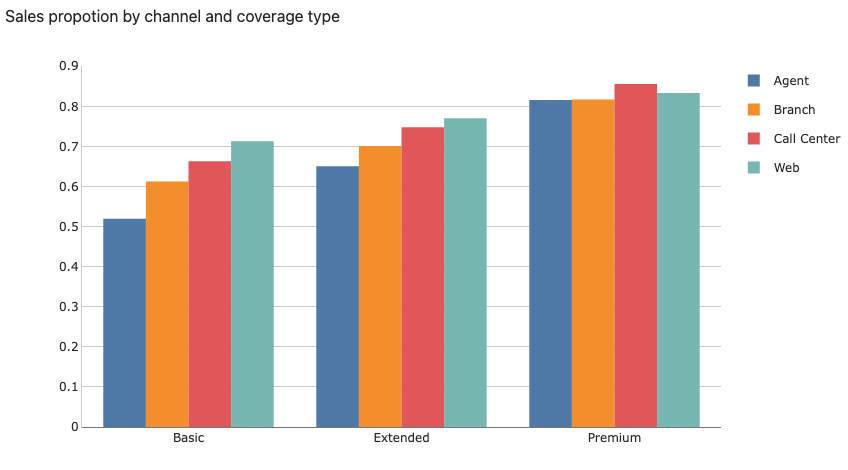

In [25]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
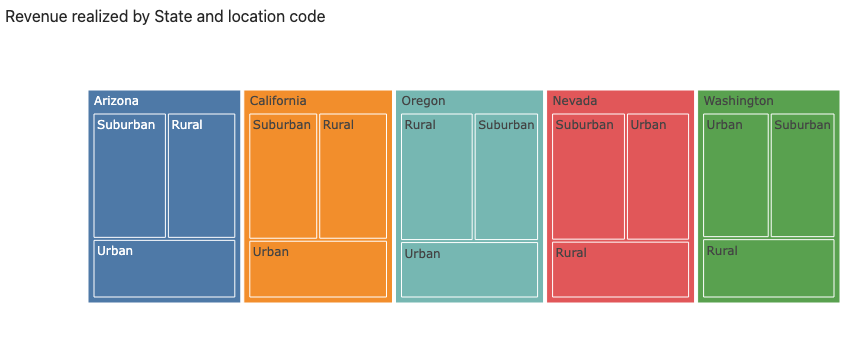

In [26]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
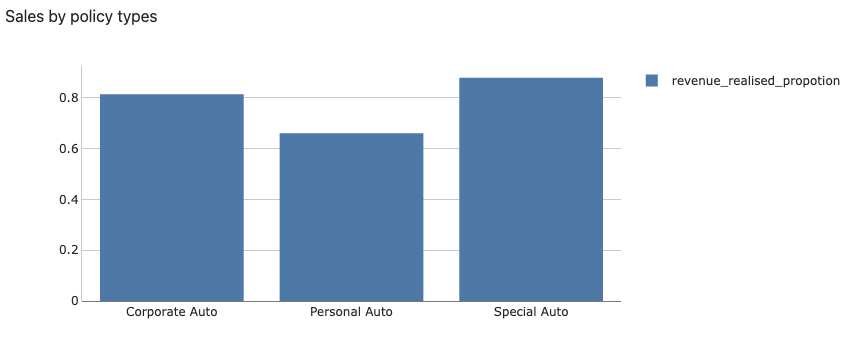

In [27]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
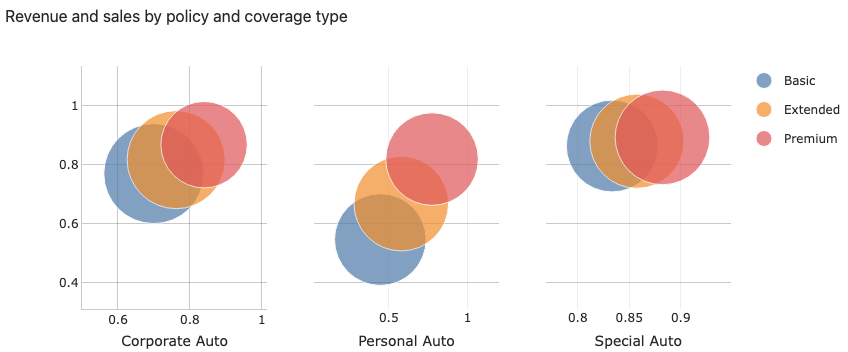

In [28]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
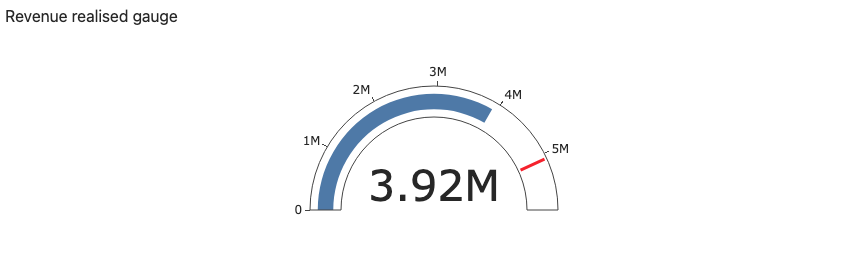

In [29]:
session.widget

In [30]:
# Let us compile all of this information in a dashboard

In [31]:
session.link / "#/dashboard/39f"

http://localhost:61201/#/dashboard/39f

# Part 3: Price Elasticity with Atoti 

We will use Atoti to do simulations and hence understand the price elasticity across different customer segments.

## Scenario 1: The pareto principle

* Increase the price by `20%` for all the policies for which sales probability is more than `80%`.
* Drop the price by `20%` for policies that have a probability to be bought less than `20%`.

This will affect the most price-sensitive customers from the customers who have not bought the policy. On the other hand, this will help identify the most price-insensitive customers from the customers who have actually bought the policy.

In [32]:
# updating the pricing based on above pareto simulation
prediction_df_pareto = prediction_df.copy()

prediction_df_pareto.loc[
    (prediction_df_pareto.sales_prediction_probability > 0.8), "Price"
] = prediction_df_pareto["Price"].apply(lambda x: x * 1.2)

prediction_df_pareto.loc[
    (prediction_df_pareto.sales_prediction_probability < 0.2), "Price"
] = prediction_df_pareto["Price"].apply(lambda x: x * 0.8)

### Using the model to make predictions on the scenario

In [33]:
X_test_pareto = X_test.copy()

X_test_pareto["Price"] = prediction_df_pareto["Price"]
test_result_pareto = xgbc.predict(X_test_pareto)
prediction_df_pareto["Sales_prediction"] = test_result_pareto.tolist()

### Creating a scenario in Atoti using the model predictions

In [34]:
predictions.scenarios["Pareto price change"].load(prediction_df_pareto)

## Scenario 2: Boost Personal Auto and basic coverage
So of all the policy types, personal auto and basic coverage are the weakest sections.  

Let us see what happens if we try to boost the personal auto lines by increasing the policy price by `25%`, and the basic coverage by `15%`.  

In [35]:
# updating the pricing
prediction_df_personal_auto = prediction_df.copy()

prediction_df_personal_auto.loc[
    (prediction_df_personal_auto.Policy_Type == "Personal Auto"), "Price"
] = prediction_df_personal_auto["Price"].apply(lambda x: x * 1.25)

prediction_df_personal_auto.loc[
    (prediction_df_personal_auto.Coverage_Type == "Basic"), "Price"
] = prediction_df_personal_auto["Price"].apply(lambda x: x * 1.15)

### Using the model to make predictions on the scenario

In [36]:
X_test_personal_auto = X_test.copy()

X_test_personal_auto["Price"] = prediction_df_personal_auto["Price"]
test_result_personal_auto = xgbc.predict(X_test_personal_auto)
prediction_df_personal_auto["Sales_prediction"] = test_result_personal_auto.tolist()

### Creating a scenario in Atoti using the model predictions

In [37]:
predictions.scenarios["Personal Auto Boost"].load(prediction_df_personal_auto)

### Scenario 3: Geographic Improvements
In the states of Oregon and Washington, suburban areas are not performing well. Therefore, we can try and drop the prices by `10%` for customers in rural areas of Oregon and drop by `15%` in urban areas of Washington to see how price-sensitive the customers in the respective segment are.

In [38]:
# updating the pricing based on above Scenario simulation
prediction_df_geo_improvement = prediction_df.copy()

prediction_df_geo_improvement.loc[
    (prediction_df_geo_improvement.State == "Oregon"), "Price"
] = prediction_df_geo_improvement["Price"].apply(lambda x: x * 0.9)

prediction_df_geo_improvement.loc[
    (prediction_df_geo_improvement.State == "Washington"), "Price"
] = prediction_df_geo_improvement["Price"].apply(lambda x: x * 0.85)

### Using the model to make predictions on the scenario

In [39]:
X_test_geo_improvement = X_test.copy()

X_test_geo_improvement["Price"] = prediction_df_geo_improvement["Price"]
test_result_geo_improvement = xgbc.predict(X_test_geo_improvement)
prediction_df_geo_improvement["Sales_prediction"] = test_result_geo_improvement.tolist()

### Creating a scenario in Atoti using the model predictions

In [40]:
predictions.scenarios["Geographical Improvements"].load(prediction_df_geo_improvement)

## Visualising Scenarios in Atoti

In Atoti, the data model is made of measures chained together. A simulation can be seen as changing one part of the model, either its source data or one of its measure definitions, and then evaluating how it impacts the following measures.  

The session now has different scenarios and the only differences between them are the lines corresponding to the price and prediction probability, **everything else is shared between the scenarios and has not been duplicated: source scenarios in Atoti are memory-efficient.**

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
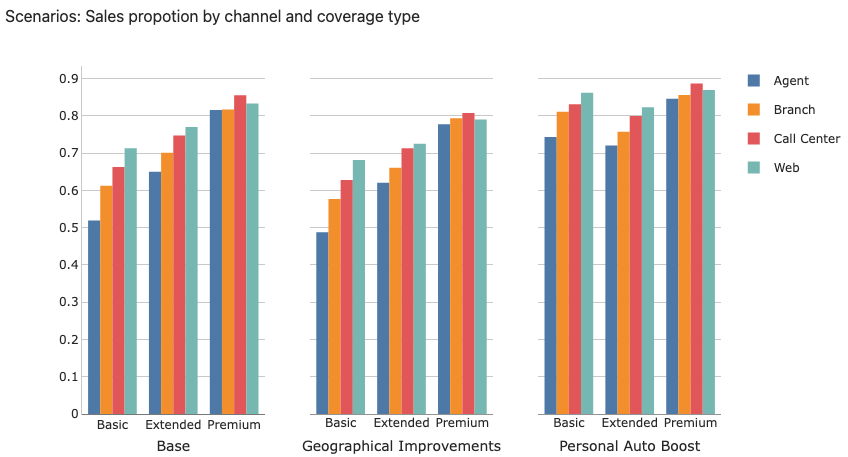

In [41]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
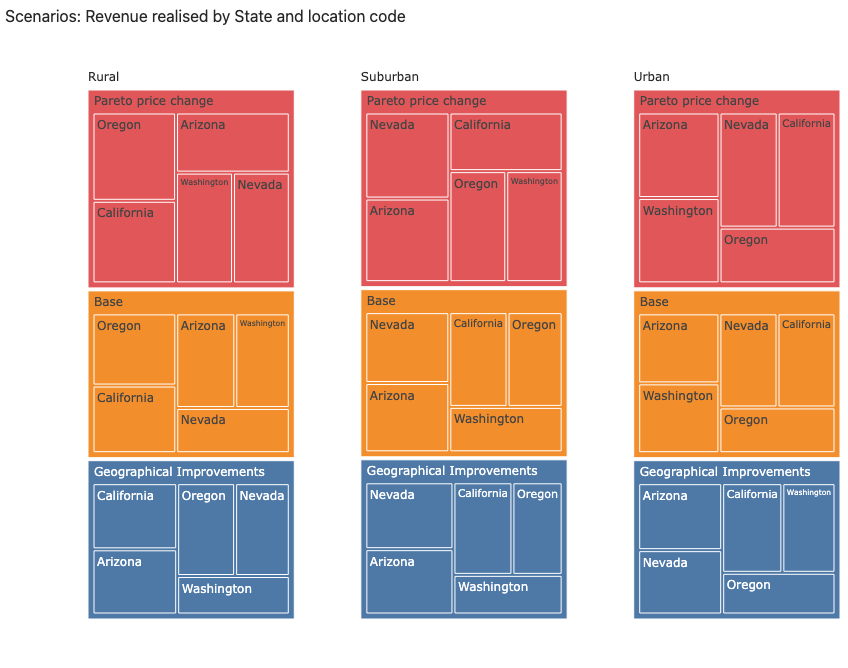

In [42]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
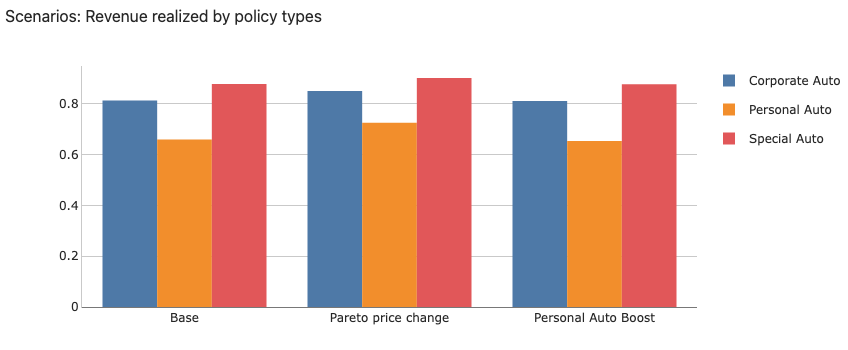

In [43]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
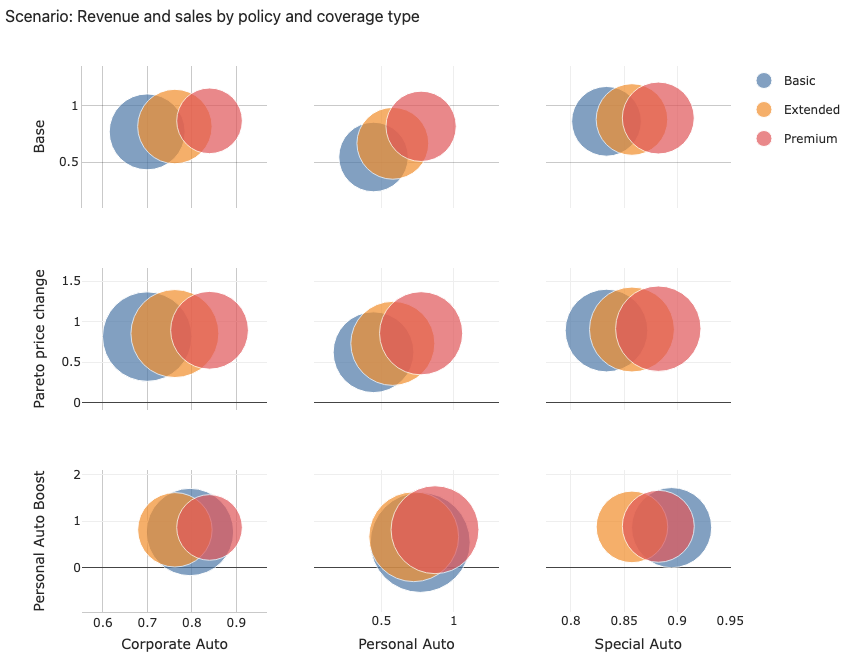

In [44]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
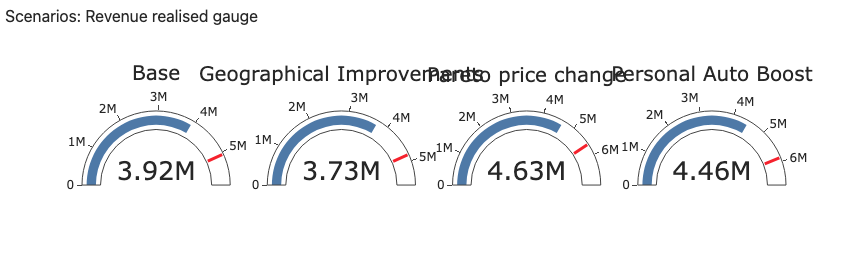

In [45]:
session.widget

## Let us summarize this information in a new tab of the dashboard we created above

In [46]:
session.link / "#/dashboard/39f"

http://localhost:61201/#/dashboard/39f

# Conclusion:

In this notebook, we used Atoti and a predictive model based on XGBosst classification.  

We saw above, how Atoti can seamlessly integrate with a predictive model to create different what-if scenarios and hence, identify the price-sensitive and insensitive customers across different segments.

**Try for yourself how Atoti can help you simplify what-if scenarios and the price elasticity of demand!**

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=price-elasticity" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>